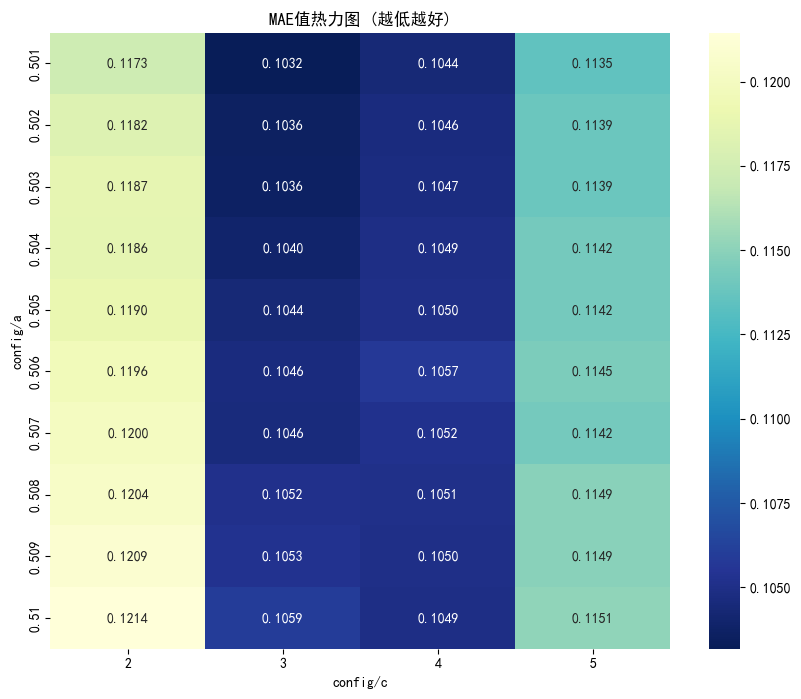

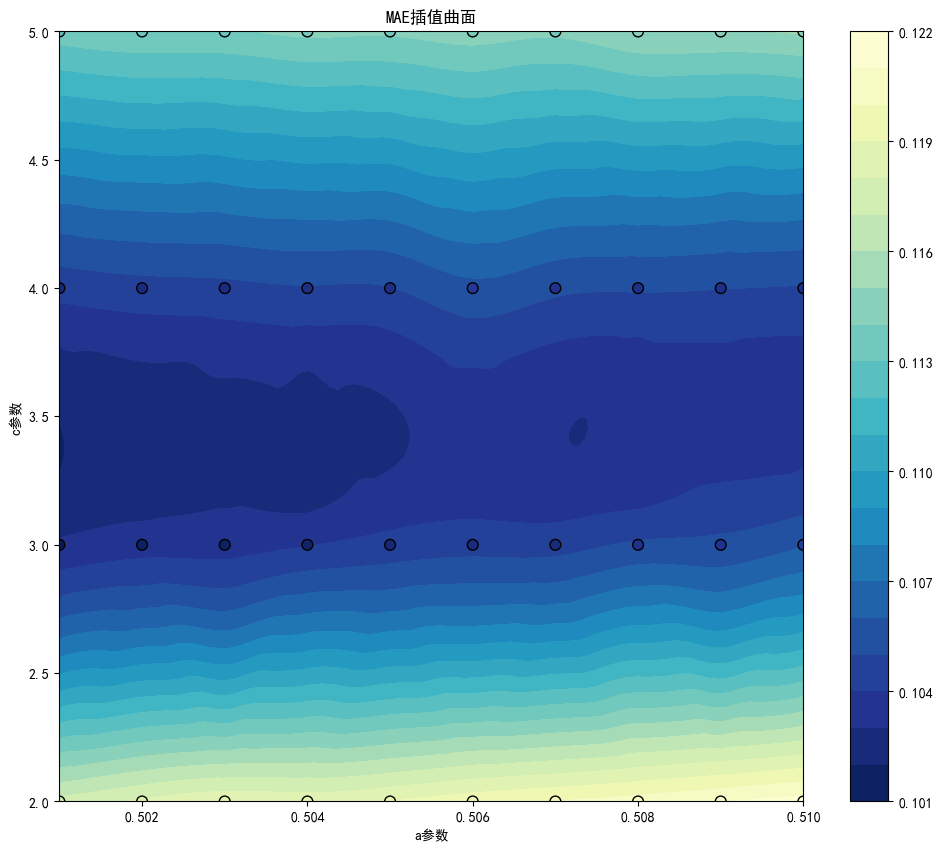

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

# 设置matplotlib支持中文显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
matplotlib.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取结果
df = pd.read_csv("/mnt/ray_tuning/ray_results/results.csv")

# 创建a和c的网格热力图
pivot_mae = df.pivot_table(index='config/a', columns='config/c', values='mae')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_mae, annot=True, fmt=".4f", cmap="YlGnBu_r")
plt.title('MAE值热力图 (越低越好)')
plt.savefig("/mnt/ray_tuning/ray_results/mae_heatmap.png")

# 拟合曲面，看是否存在最优点
from scipy.interpolate import griddata

a_values = df['config/a'].unique()
c_values = df['config/c'].unique()
a_grid, c_grid = np.meshgrid(np.linspace(min(a_values), max(a_values), 100), 
                             np.linspace(min(c_values), max(c_values), 100))
mae_interp = griddata((df['config/a'], df['config/c']), df['mae'], 
                      (a_grid, c_grid), method='cubic')

plt.figure(figsize=(12, 10))
contour = plt.contourf(a_grid, c_grid, mae_interp, 20, cmap='YlGnBu_r')
plt.colorbar(contour)
plt.scatter(df['config/a'], df['config/c'], c=df['mae'], cmap='YlGnBu_r', 
            edgecolor='k', s=60)
plt.xlabel('a参数')
plt.ylabel('c参数')
plt.title('MAE插值曲面')
plt.savefig("/mnt/ray_tuning/ray_results/mae_surface.png")